# Medical project

## Historical data

In [8]:
import numpy as np
import pandas as pd

X = pd.read_csv('../../data/medical/historical_X.dat', header=None, sep=" ")
A = pd.read_csv('../../data/medical/historical_A.dat', header=None, sep=" ")
Y = pd.read_csv('../../data/medical/historical_Y.dat', header=None, sep=" ")
X = X.rename(index=str, columns={0: 'gender', 1: 'smoker'})
X = X.rename(index=str, columns={i: 'gene'+str(i-1) for i in range(2,128)})
X_old = X.copy()
X.insert(0, 'symptoms', X[128] + X[129]*2)
X = X.drop(labels=[128, 129], axis=1)
A = A.rename(index=str, columns={0: 'action'})
Y = Y.rename(index=str, columns={0: 'outcome'})

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set()

### Discovering structure in the data

#### a)

In [5]:
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from scipy.stats import sem

In [17]:
n_cluster = np.arange(1,15,2)
scores_mean = np.zeros(len(n_cluster))
scores_sem = np.zeros(len(n_cluster))
for i, n in enumerate(n_cluster):
    scores = np.zeros(10)
    for j, (train, test) in enumerate(KFold(n_splits=10).split(X_old)):
        kmeans = KMeans(n_clusters=n).fit(X.iloc[train])
        scores[j] = kmeans.score(X.iloc[test])
    
    scores_mean[i] = scores.mean()
    scores_sem[i] = sem(scores)

<BarContainer object of 7 artists>

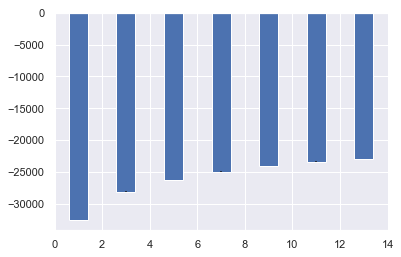

In [18]:
plt.bar(x=n_cluster, height=scores_mean, yerr=scores_sem)

OK, we have to do something different, because KMeans will just look better and better the more clusters we use (I also tried np.arange(1,150,20)).

From [SKlearn](http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) documentation it looks like Hierarchical Clustering might be a good way to go, but we need to define a metric for similarity. In [A Survey of Binary Similarity and Distance Measures by Choi et al, 2010](http://www.iiisci.org/Journal/CV$/sci/pdfs/GS315JG.pdf) there are 76 potential similarity/distance measures listed. It's difficult to make a very informed decision as to which is the best in our scenario, but we should be able to find one so that we don't have to invent one on our own. It looks as though our features are symmetric (that both 0 and 1 encode some state) and not asymetric (that 0 encodes absence of something and 1 presence) as the mean sum of the genetic features is 64.6 from a total of 126 and the gender is obvious. The exceptions are smoker and the two symptons features, although smoker could also be considered symmetric.

For the symmetric features match ratio (Sokal&Michener) seems as good as any, whereas for the asymetric Faith-similarity where negative matches are downplayed seems like a good idea. I don't suppose there is anything wrong in combining them, though given how few asymetric features we have we could just as well have used S&M on all. Given the fact that scipy.spatial.distance has a metric sokalmichener that seems like the best way to go.

Now, with the AgglomerativeClustering in SKLearn we don't have a score or a predict method. It seems we can only fit, or fit and predict on the same dataset. There is, however, some measures of cluster fit that can be used, such as silhouette score. I was also considering something like doing CV and predicting every time on the training set, then storing the 9 labels we get from this and creating some measure of how similar the 9 labels created when fitting the clustering on different data, but one big problem with this is how to judge which number of clusters is best. Obviously we'll get perfect score on this if we use 1 cluster. The more clusters the bigger the chance of having differences in the classification. Balancing that well would be hard.

I also came across [Powered Outer Probabilistic Clustering, Taraba, 2017](http://www.iaeng.org/publication/WCECS2017/WCECS2017_pp394-398.pdf) which looks interesting and well suited to our binary data, but it doesn't seem to have caught on, and it would have to be implemented from scratch. To get any kind of efficiency that would probably need to be done in C using Cython or something, and even though C#-code is provided it was an unsurmountable obstacle for this project.

In [36]:
X.iloc[:].iloc[3:].sum(axis=1).mean()

64.58447534260279

In [48]:
from scipy.spatial.distance import sokalmichener
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, pairwise_distances

In [43]:
distances.shape

(10000, 10000)

In [ ]:
distances = pairwise_distances(X_old, metric=sokalmichener)

In [45]:
n_cluster = np.arange(1,9)
scores = np.zeros_like(n_cluster)
labels = np.zeros(len(X_old), len(n_cluster))
for i, n in enumerate(n_cluster):
    clusterer = AgglomerativeClustering(n_clusters=n, affinity='precomputed', 
                                        linkage="average")
    labels[:,i] = clusterer.fit_predict(distances)
    scores[i] = silhouette_score(distances, labels[:,i], metric='precomputed')

<BarContainer object of 7 artists>

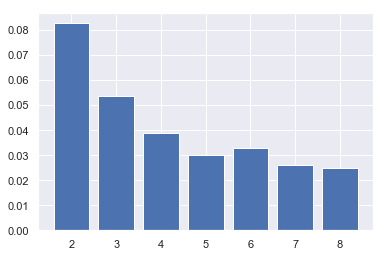

In [46]:
plt.bar(n_cluster[1:], scores[1:])

The silhouette score is not defined for a single cluster, so we can only judge multiple clusters. We see from the scores however, that no matter the number of clusters there is a significant overlap between the clusters. 2 clusters seem best, but at the same time they have so significant overlap that we might as well have concluded that they in are a single cluster.

We can always try instead of silhouette to calculate the probabilities of seeing the data given their labelling and the number of clusters, then compare the total likelihood for each cluster-size.

Lets try with a Bayesian mixture model

In [3]:
import pymc3 as pm

In [28]:
X_part = X_old.iloc[:2000, [3,5,11,113,-2,-1]].copy()
k = 2
N, p = X_part.shape
model = pm.Model()
with model:
    # Probability of each cluster
    p_c = pm.Dirichlet('p_c', a=np.ones(k), shape=(k,))
    # cluster label for each x
    label = pm.Categorical('label', p=p_c, shape=N)
    # feature probabilities
    p_xi = pm.Beta('p_xi', alpha=np.ones(p), beta=np.ones(p), shape=(k,p))
    # data probability
    xi = pm.Bernoulli('xi', p=p_xi[label], shape=(k,p), observed=X_part)

In [73]:
X_part = X_old[0:200].copy()
k = 2
N, p = X_part.shape
model = pm.Model()
with model:
    # weights
    w = pm.Dirichlet('w', a=np.array([1.]*k))
    # feature probabilities
    ps = pm.Beta('ps', alpha=1, beta=1, shape=k)
    # data probability
    components = pm.Bernoulli.dist('components', p=ps, shape=k)
    # log likelihood
    log_like = pm.Mixture('log_like', w=w, comp_dists=components, observed=X_part)

TypeError: __init__() got multiple values for argument 'p'

In [29]:
with model:
    step = pm.NUTS()
    tr = pm.sample(10000, step=[step], cores=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [p_xi, p_c]
>BinaryGibbsMetropolis: [label]
Sampling 2 chains:   0%|                                                       | 11/21000 [00:12<6:59:23,  1.20s/draws]


ValueError: Not enough samples to build a trace.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A5894E4978>,
      dtype=object)

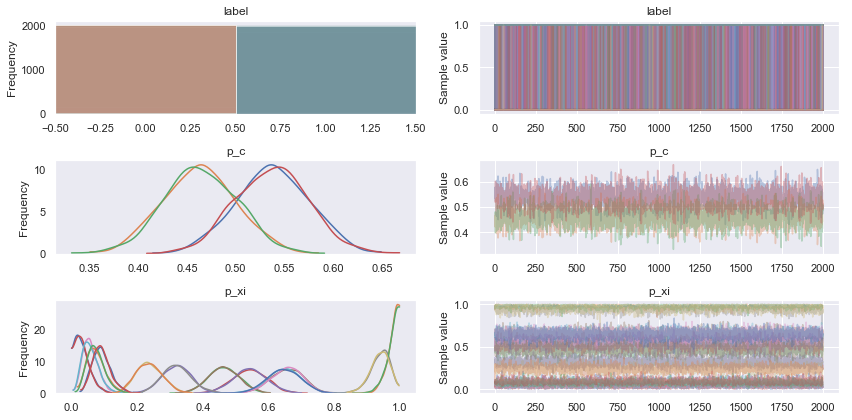

In [18]:
pm.plots.traceplot(tr)

In [19]:
tr['label'][-1]

array([1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1], dtype=int64)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


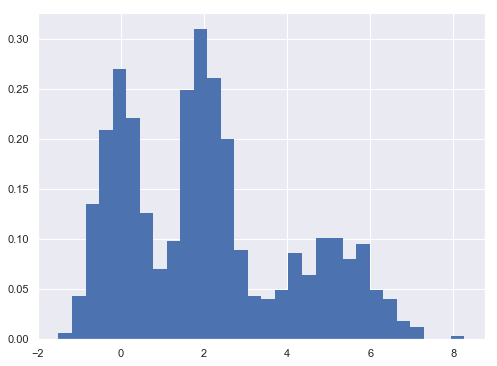

In [4]:
np.random.seed(383561) # from random.org, for reproducibility
N = 1000
W = np.array([0.35, 0.4, 0.25])
MU = np.array([0., 2., 5.])
SIGMA = np.array([0.5, 0.5, 1.])
component = np.random.choice(MU.size, size=N, p=W)
x = np.random.normal(MU[component], SIGMA[component], size=N)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(x, bins=30, normed=True, lw=0);

In [5]:
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones_like(W))

    mu = pm.Normal('mu', 0., 10., shape=W.size)
    tau = pm.Gamma('tau', 1., 1., shape=W.size)

    x_obs = pm.NormalMixture('x_obs', w, mu, tau=tau, observed=x)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '16980' (I am process '5508')


In [6]:
with model:
    trace = pm.sample(5000, n_init=10000, tune=1000, random_seed=383561)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, mu, w]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 12000/12000 [01:05<00:00, 183.67draws/s]
C:\ProgramData\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


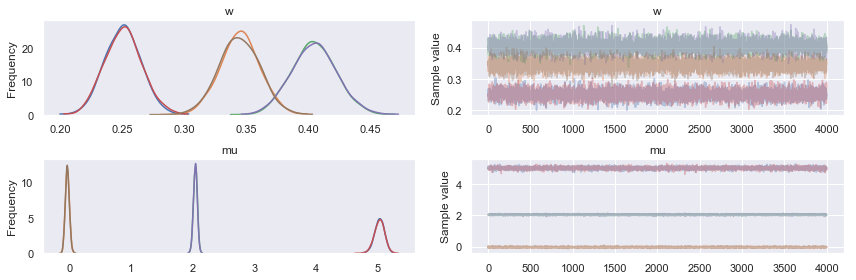

In [7]:
pm.traceplot(trace, varnames=['w', 'mu']);

#### b)

In [12]:
from sklearn.linear_model import LogisticRegression

In [33]:
clf = LogisticRegression(penalty='l1', C=0.1)
#fit = clf.fit(X.drop(labels=['symptoms'], axis=1), X['symptoms'])
fit = clf.fit(X_old, Y.values.ravel())
fit.coef_

array([[ 1.10250143e-01, -2.18757938e-01, -3.41615968e-01,
         0.00000000e+00,  1.39196438e-01,  0.00000000e+00,
         0.00000000e+00, -1.30607061e-01, -4.13906114e-02,
        -4.40029169e-01, -1.02416687e-01, -3.38434821e-01,
        -4.52215754e-02, -1.51457530e-01, -1.58218497e-01,
         0.00000000e+00, -5.22322903e-01,  0.00000000e+00,
        -9.87418307e-02,  3.55730122e-01,  0.00000000e+00,
        -3.10309197e-01, -4.97751996e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.14111208e-01,
         0.00000000e+00, -1.14018377e-01,  0.00000000e+00,
         0.00000000e+00, -1.79576159e-01,  8.30830836e-02,
        -1.06236254e-01,  0.00000000e+00,  1.74648799e-01,
         9.41408396e-02, -2.38616005e-02, -5.11222426e-02,
        -1.08113444e-01,  0.00000000e+00, -6.84283560e-02,
         0.00000000e+00, -4.33300656e-03,  1.11254689e-01,
         2.58092756e-01,  0.00000000e+00, -6.77467996e-02,
         3.45865084e-01, -7.08906836e-02,  2.68891198e-0

In [34]:
1*(fit.coef_[:,:]>np.zeros(fit.coef_.shape[1])).sum(axis=1)

array([25])

In [46]:
(1+fit.coef_[:,:]>np.zeros(fit.coef_.shape[1])*-1)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

### Measuring the effect of actions

How are outcomes measured? I assume action 0 and 1 refer to placebo or active intervention, not necessarily in that order, but do we then apply some intervention also to those without symptoms? How do we define healed/not on someone without symptoms?

In [22]:
responses = np.zeros([2,2])
for a, y in zip(A.values, Y.values):
    responses[a,y] += 1
responses

array([[7633.,   69.],
       [ 946., 1352.]])

In [25]:
A.sum()

action    2298
dtype: int64